# Combining SeuratObjects

The joint analysis of two or more single-cell datasets poses unique challenges. In particular, identifying cell populations that are present across multiple datasets can be problematic under standard workflows. 

Below is an example of merging of two datasets and the batch effects which can be seen between them.  After that is an example of integration of the two datasets with Harmony.

## Setup the Seurat objects

We can access this dataset through the `SeuratData` package.

The `SeuratData` package along with the `multtest` and `metap` packages which will be used in `FindConservedMarkers()` in the integrated SeuratObject are not already installed in the docker.  To install them, uncomment out the code below (remove the #'s) and run.  After installation go ahead and recommemnt out the code to prevent accidentally rerunning.  Rerunning won't break anything, it will just take time.

In [1]:
#devtools::install_github('satijalab/seurat-data')
#BiocManager::install('multtest')
#install.packages('metap')
#install.packages('harmony')

Now we can install and load the ifnb dataset.

In [2]:
options(warn=-1)
library(Seurat)
library(SeuratData)
library(patchwork)
library(ggplot2)
library(harmony)

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Installed datasets ───────────────────────────────────── SeuratData v0.2.1 ──

✔ ifnb 3.1.0                            


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Loading required package: Rcpp



In [3]:
# install dataset
options(warn=-1)
InstallData("ifnb")

In [4]:
# load dataset
options(warn=-1)
LoadData("ifnb")

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

In [5]:
head(ifnb@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations
,<chr>,<dbl>,<int>,<chr>,<fct>
AAACATACATTTCC.1,IMMUNE_CTRL,3017,877,CTRL,CD14 Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481,713,CTRL,CD14 Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420,850,CTRL,CD14 Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156,1109,CTRL,pDC
AAACATACGATGAA.1,IMMUNE_CTRL,1868,634,CTRL,CD4 Memory T
AAACATACGGCATT.1,IMMUNE_CTRL,1581,557,CTRL,CD14 Mono


In [6]:
unique(ifnb$orig.ident)

[1] "IMMUNE_CTRL" "IMMUNE_STIM"

In [7]:
unique(ifnb$stim)

[1] "CTRL" "STIM"

In [8]:
levels(ifnb$seurat_annotations)

[1] "CD14 Mono"    "CD4 Naive T"  "CD4 Memory T" "CD16 Mono"    "B"           
 [6] "CD8 T"        "T activated"  "NK"           "DC"           "B Activated" 
[11] "Mk"           "pDC"          "Eryth"

In [9]:
# split the dataset into a list of two seurat objects (stim and CTRL)
ifnb.list <- SplitObject(ifnb, split.by = "stim")
ifnb.list

$CTRL
An object of class Seurat 
14053 features across 6548 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

$STIM
An object of class Seurat 
14053 features across 7451 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)


### Preprocess Seurat Objects

If you have your own data that you've preprocessed as individual samples, they will already be normalized and have variable features.  If you had SeuratObjects called sample1 and sample2, you can put them into a list with:

`seurat.list <- list(sample1, sample2)`

The infb.list consists of two Seurat Objects named CTRL and STIM.  We could preprocess each of these from NormalizeData through FindClusters with the individual steps we've learned:

`infb.list$CTRL <- NormalizeData(infb.list$CTRL)`

`infb.list$CTRL <- FindVariableFeatures(infb.list$CTRL, selection.method = "vst", nfeatures = 2000)`

`etc...`

But we can also take advantage of the R function `lapply()` which applies a function or series of functions for each object in a list.  

In [10]:
# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    x <- ScaleData(x, verbose = FALSE)
    x <- RunPCA(x, npcs = 30, verbose = FALSE)
    x <- RunUMAP(x, reduction = "pca", dims = 1:30, verbose = FALSE)
    x <- FindNeighbors(x, reduction = "pca", dims = 1:30, verbose = FALSE)
    x <- FindClusters(x, resolution = 0.5, verbose = FALSE)
})

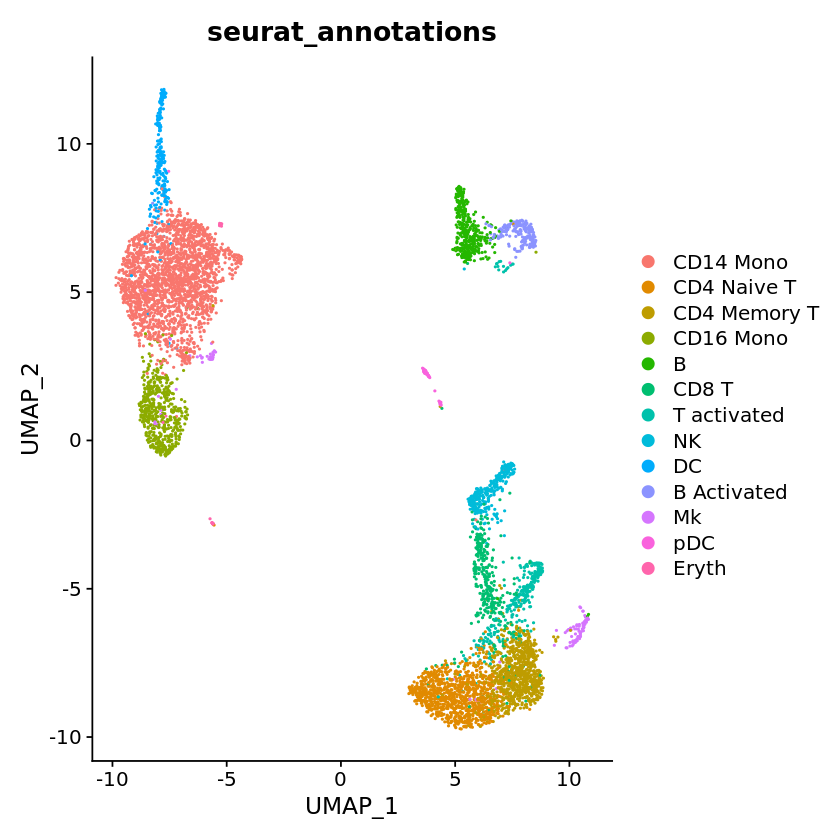

In [11]:
DimPlot(ifnb.list$CTRL, group.by = "seurat_annotations")

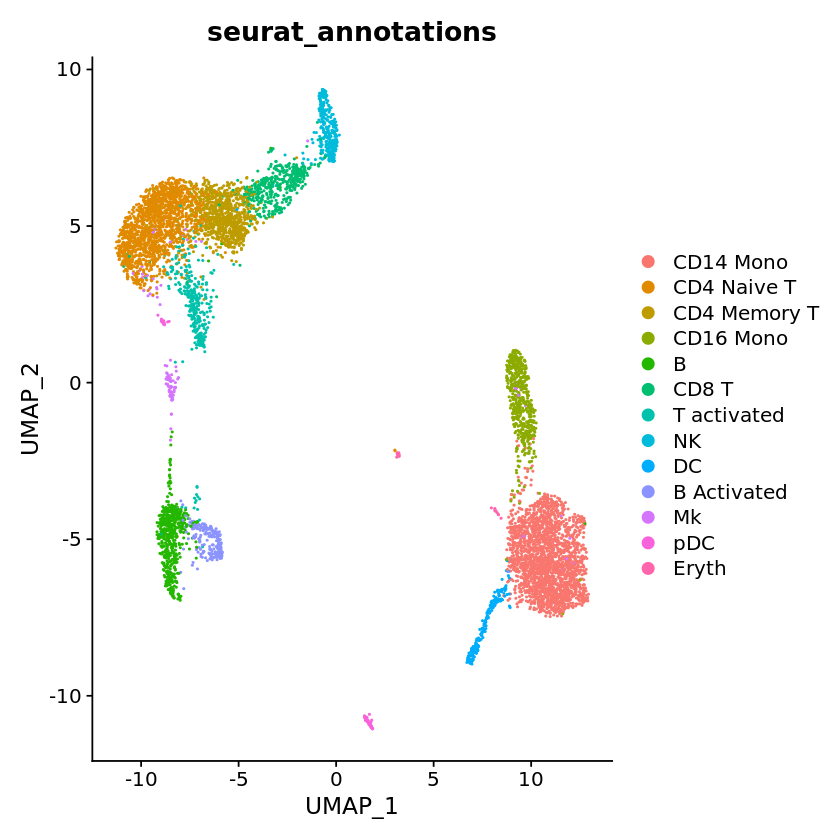

In [12]:
DimPlot(ifnb.list$STIM, group.by = "seurat_annotations")

### Merge Seurat Objects without integrating

We can use `merge()` to combine the two SeuratObjects into one SeuratObject.  This is *not* integrating the SeuratObjects.

Note that after we merge the objects we can again preprocess them from `FindVariabelFeatures()` through `FindClusters()`.  This preprocessing will use all cells in the merged object and will write over the preprocessing done on each individual SeuratObject.

It's best to use the normalization done on the individual samples.

In [13]:
ifnb.merge <- merge(ifnb.list$CTRL, y = ifnb.list$STIM, add.cell.ids = c("ctrl", "stim"), project = "ifnb.merged",
    merge.data = TRUE)

In [14]:
ifnb.merge <- FindVariableFeatures(ifnb.merge, selection.method = "vst", nfeatures = 2000)
ifnb.merge <- ScaleData(ifnb.merge, verbose = FALSE)
ifnb.merge <- RunPCA(ifnb.merge, npcs = 30, verbose = FALSE)
ifnb.merge <- RunUMAP(ifnb.merge, reduction = "pca", dims = 1:30, verbose = FALSE)
ifnb.merge <- FindNeighbors(ifnb.merge, reduction = "pca", dims = 1:30, verbose = FALSE)
ifnb.merge <- FindClusters(ifnb.merge, resolution = 0.5, verbose = FALSE)

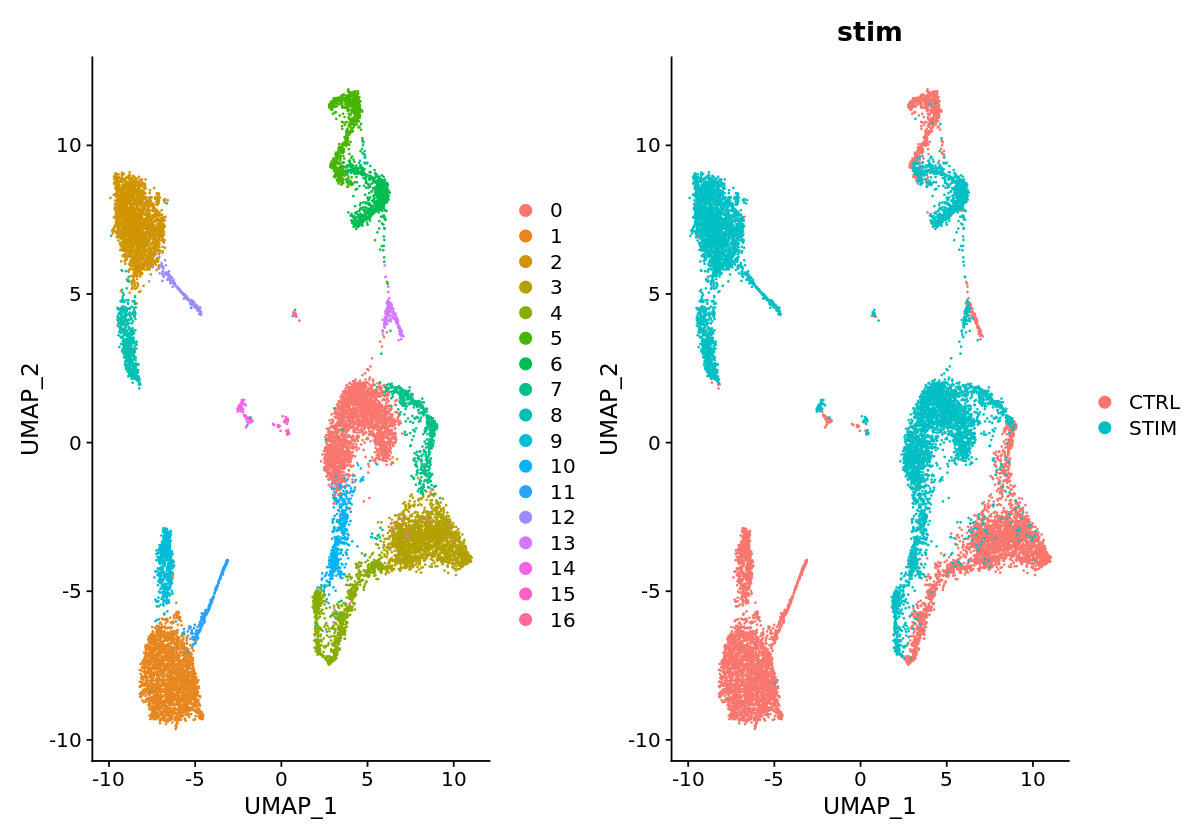

In [15]:
options(repr.plot.width=10, repr.plot.height=7)
p1 <- DimPlot(ifnb.merge)
p2 <- DimPlot(ifnb.merge, group.by = "stim")
p1 + p2

### Harmony Integration

The Harmony integration algorithm was reported by [Korsunsky et al 2019](https://www.nature.com/articles/s41592-019-0619-0).  [Harmony](https://github.com/immunogenomics/harmony) is an algorithm that projects cells into a shared embedding in which cells group by cell type rather than dataset-specific conditions. Harmony simultaneously accounts for multiple experimental and biological factors.

In [16]:
ifnb.merge <- RunHarmony(ifnb.merge, assay.use = "RNA", group.by.vars = "stim")
ifnb.merge <- RunUMAP(ifnb.merge, reduction = "harmony", dims = 1:30, verbose = F)
ifnb.merge <- FindNeighbors(ifnb.merge,reduction = "harmony", verbose = F, dims = 1:30)
ifnb.merge <- FindClusters(ifnb.merge, resolution = 0.5, verbose = F)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations



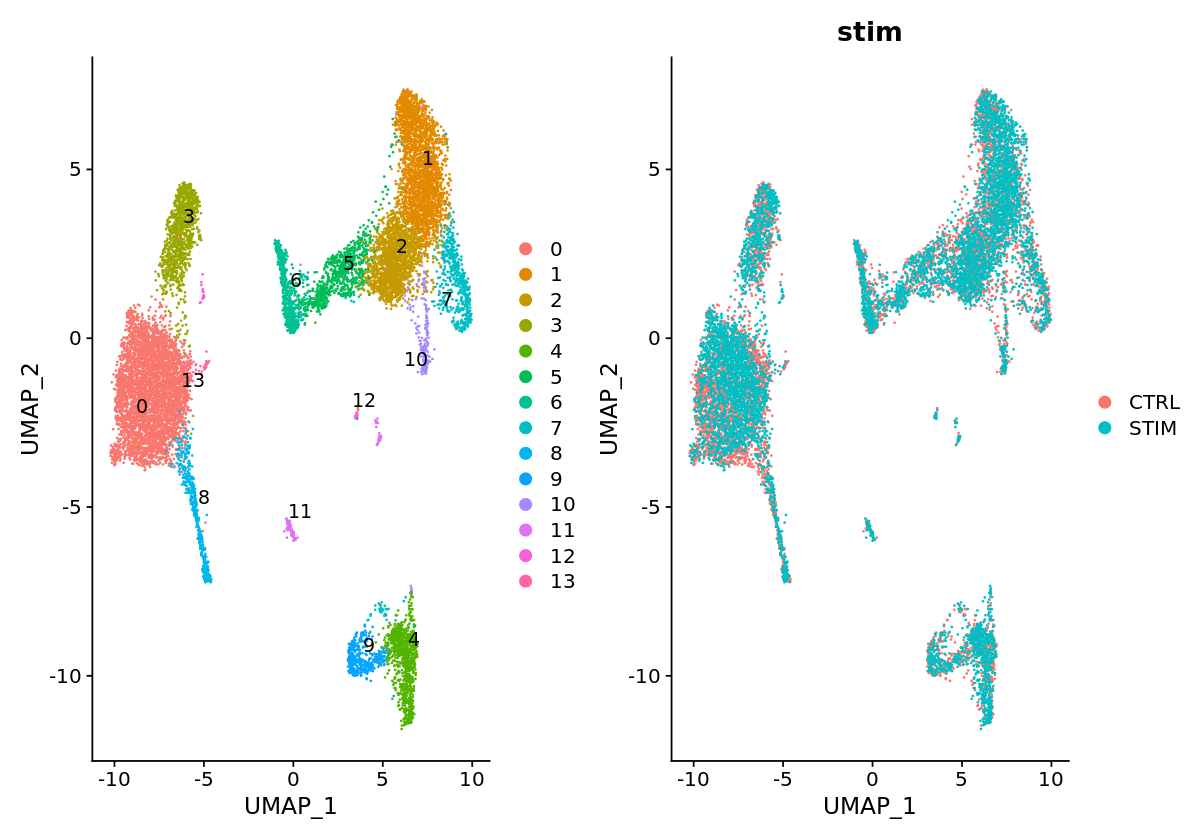

In [17]:
p3 <- DimPlot(ifnb.merge, label = T, repel = T)
p4 <- DimPlot(ifnb.merge, group.by = "stim")
p3 + p4

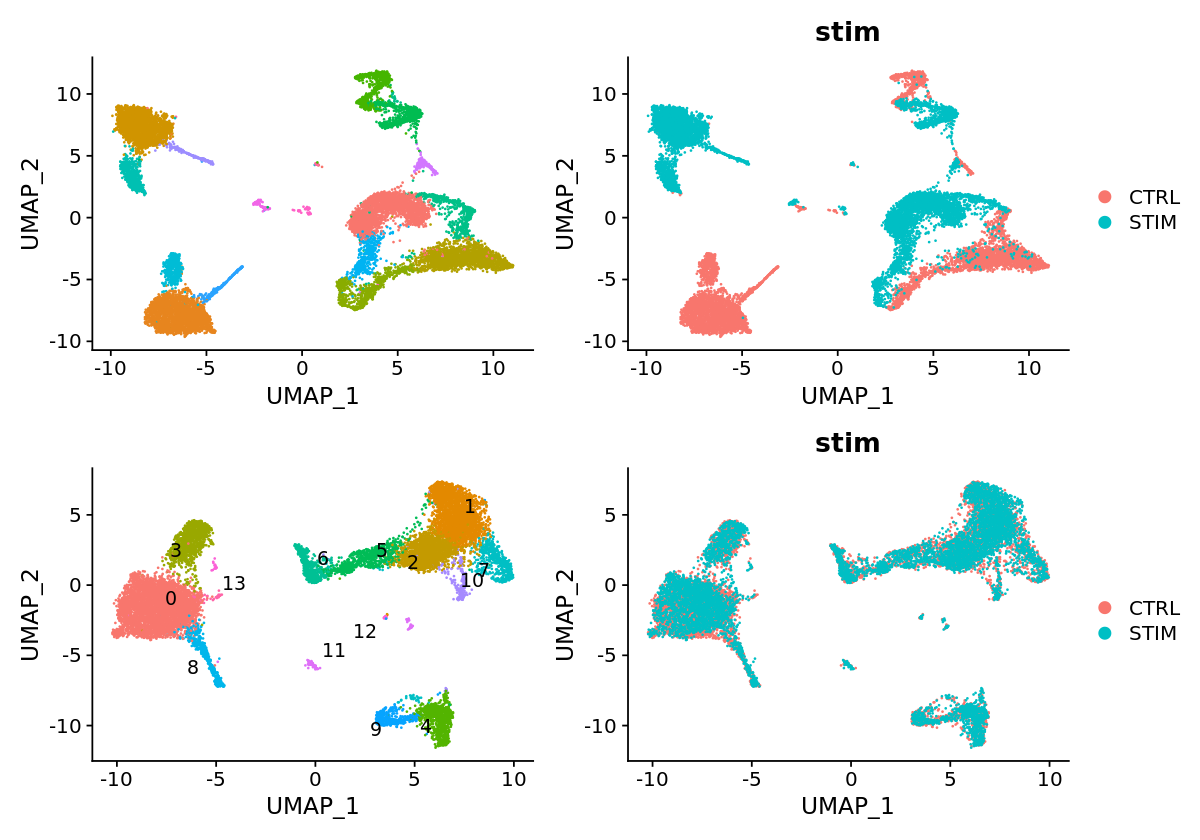

In [18]:
(p1 + NoLegend() + p2)/(p3 + NoLegend() + p4)

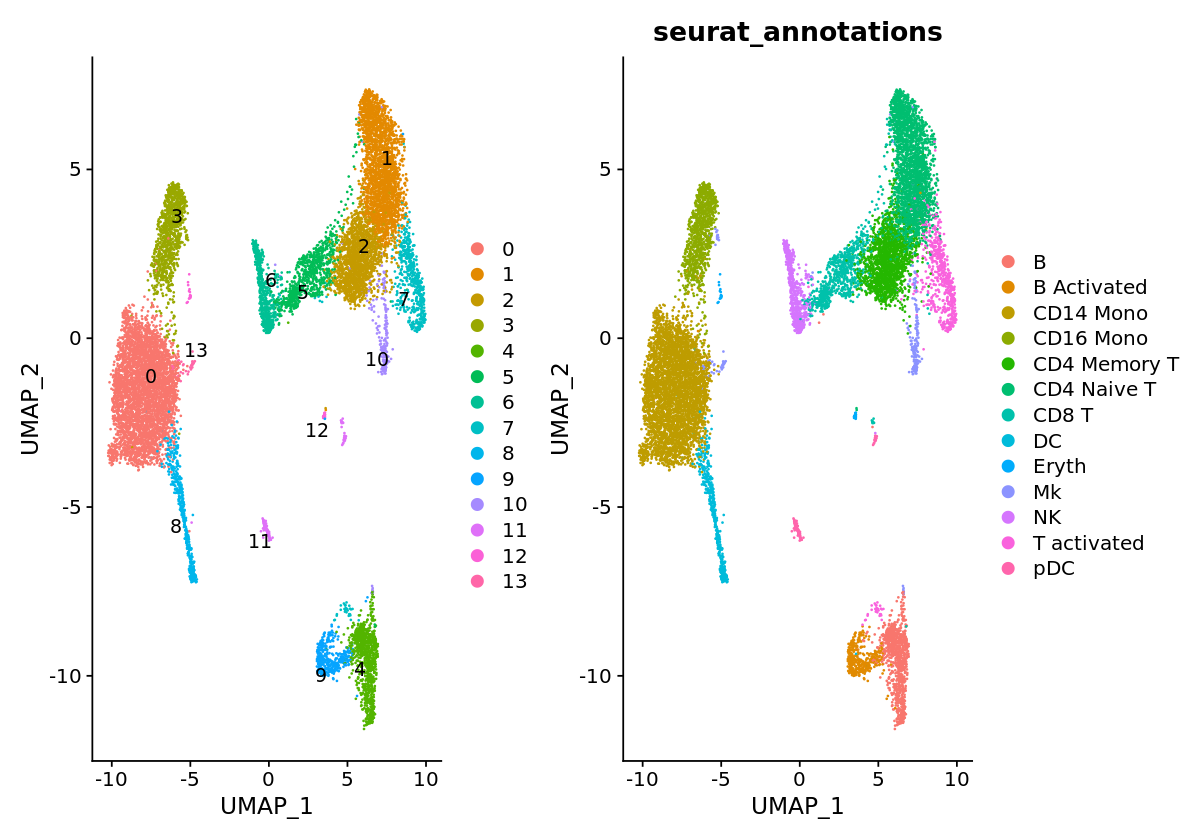

In [19]:
p5 <- DimPlot(ifnb.merge, group.by = "seurat_annotations")
p3 + p5